In [ ]:
%pip install -q git+https://github.com/yfukai/BaSiCPy@autosegment
%pip install -q plotly==5.4.0

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.1/64.1 kB 781.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 17.8 MB/s eta 0:00:00


In [ ]:
import xarray

print(xarray.__version__)
import numpy as np
from os import path
import os

# from aicsimageio import AICSImage
# from aicspylibczi import CziFile
from tqdm import tqdm
from itertools import product
from matplotlib import pyplot as plt
from skimage.io import imread, imread_collection, imsave
from skimage.io import imshow_collection
import pandas as pd
from skimage.transform import resize
from skimage import filters
from skimage.morphology import binary_dilation, binary_erosion, disk, square

# from cucim.skimage.morphology import binary_erosion, disk

from skimage.filters import threshold_multiotsu
from basicpy import BaSiC
from basicpy.metrics import autotune_cost, entropy, fourier_L0_norm

2023.7.0


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import glob

# file_path = "/content/drive/MyDrive/Colab Notebooks/BaSiCPy-dev/Simulation/simulatedimages/"
file_path = (
    "/content/drive/MyDrive/Colab Notebooks/BaSiCPy/Simulated_data/simulatedimages/"
)
# background
bg_file = file_path + "background/FITC_20x.tif"
bg_image = imread(bg_file)

# foreground files
fg_files = glob.glob(file_path + "movie/foreground/*.png")
seg_files = glob.glob(file_path + "movie/segmentation/*.png")

nuc_channel_idx = 2
cyto_channel_idx = 0

In [ ]:
fg_images = np.array(imread_collection(fg_files))
seg_images = np.array(imread_collection(seg_files))
print(fg_images.shape)
print(seg_images.shape)

(200, 256, 256, 3)
(200, 256, 256, 3)


In [ ]:
bg_image2 = resize(bg_image, fg_images.shape[1:3])
flatfield_true = bg_image2 / bg_image2.mean()

In [ ]:
np.save(path.join(file_path, f"flatfield_true.npy"), flatfield_true)

In [ ]:
flatfield_true = np.load(path.join(file_path, f"flatfield_true.npy"))

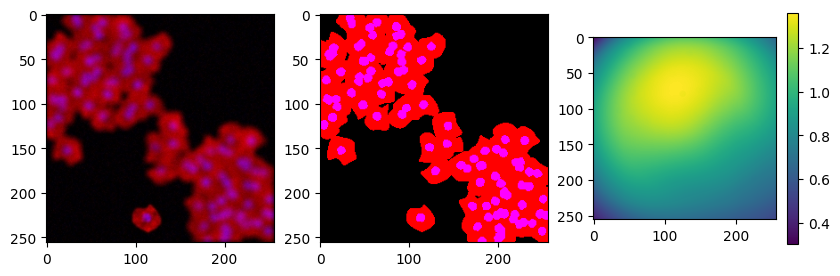

In [ ]:
plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.imshow(fg_images[100])
plt.subplot(132)
plt.imshow(seg_images[100])
plt.subplot(133)
plt.imshow(flatfield_true)
plt.colorbar()

<Axes: >

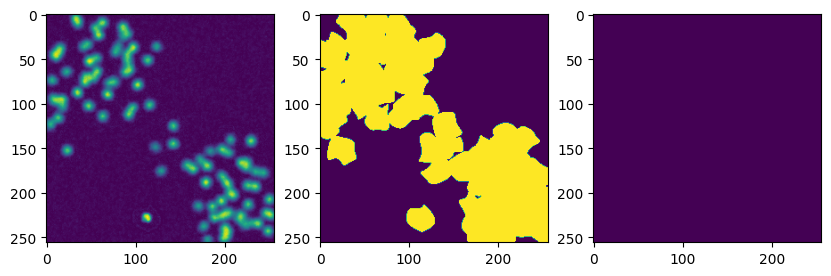

In [ ]:
plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.imshow(fg_images[100][:, :, nuc_channel_idx])
plt.subplot(132)
plt.imshow(seg_images[100][:, :, cyto_channel_idx])
plt.subplot(133)
plt.imshow(seg_images[100][:, :, 1])
plt.subplot(133)

In [ ]:
assert np.all(seg_images[:, :, :, 1] == 0)
assert np.all(seg_images[:, :, :, 1] == 0)

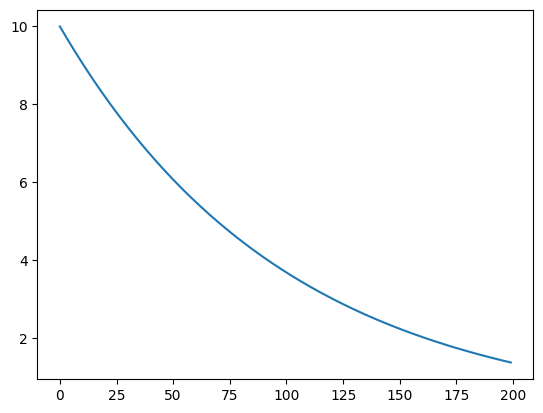

In [ ]:
ts = np.arange(seg_images.shape[0])
baseline_true = np.exp(-ts * 0.01) * 10
plt.plot(ts, baseline_true)

In [ ]:
weights = seg_images == 0
weights = np.moveaxis(weights, -1, 0)
print(weights.shape)
weights = np.array(
    [[binary_erosion(w2, footprint=square(11)) for w2 in w] for w in weights]
)

(3, 200, 256, 256)


In [ ]:
imsave(path.join(file_path, "weights.tif"), weights)

<ipython-input-14-5053227aace8>:1: UserWarning: /content/drive/MyDrive/Colab Notebooks/BaSiCPy/Simulated_data/simulatedimages/weights.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(path.join(file_path,"weights.tif"),weights)


In [ ]:
weights = imread(path.join(file_path, "weights.tif"))

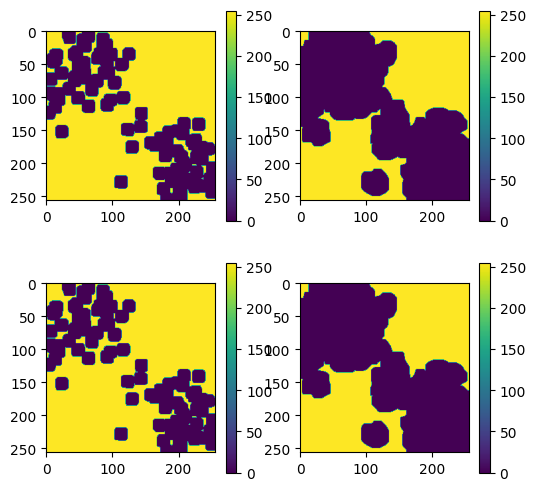

In [ ]:
plt.figure(figsize=(6, 6))
plt.subplot(221)
plt.imshow(weights[nuc_channel_idx, 100])
plt.colorbar()
plt.subplot(222)
plt.imshow(weights[cyto_channel_idx, 100])
plt.colorbar()
plt.subplot(223)
plt.imshow(weights[nuc_channel_idx, 100])
plt.colorbar()
plt.subplot(224)
plt.imshow(weights[cyto_channel_idx, 100])
plt.colorbar()

In [ ]:

images_distorted_wo_darkfield = (
    baseline_true[np.newaxis, :, np.newaxis, np.newaxis] + np.moveaxis(fg_images, -1, 0)
) * flatfield_true[np.newaxis, np.newaxis, ...]
# images_distorted_wo_darkfield += np.random.randn(*images_distorted_wo_darkfield.shape)
darkfield_true = np.ones_like(flatfield_true) * 10
images_distorted_w_darkfield = (
    baseline_true[np.newaxis, :, np.newaxis, np.newaxis] + np.moveaxis(fg_images, -1, 0)
) * flatfield_true[np.newaxis, np.newaxis, ...] + darkfield_true
# images_distorted_w_darkfield += np.random.randn(*images_distorted_w_darkfield.shape)
# images_distorted_w_darkfield = filters.gaussian(np.random.poisson(images_distorted_w_darkfield),sigma=1,preserve_range=True)

In [ ]:
np.save(path.join(file_path, f"darkfield_true.npy"), darkfield_true)
np.save(path.join(file_path, f"baseline_true.npy"), baseline_true)

In [ ]:
darkfield_true = np.load(path.join(file_path, f"darkfield_true.npy"))
baseline_true = np.load(path.join(file_path, f"baseline_true.npy"))

In [ ]:
imsave(path.join(file_path, "wo_darkfield2.tif"), images_distorted_wo_darkfield)
imsave(path.join(file_path, "w_darkfield2.tif"), images_distorted_w_darkfield)

In [ ]:
images_distorted_wo_darkfield = imread(path.join(file_path, "wo_darkfield2.tif"))
images_distorted_w_darkfield = imread(path.join(file_path, "w_darkfield2.tif"))

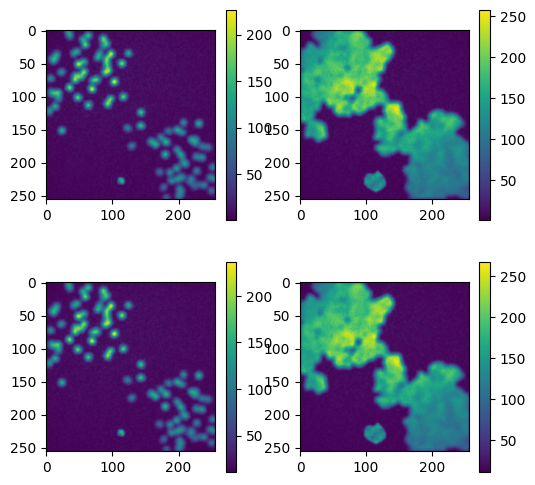

In [ ]:
plt.figure(figsize=(6, 6))
plt.subplot(221)
plt.imshow(images_distorted_wo_darkfield[nuc_channel_idx, 100])
plt.colorbar()
plt.subplot(222)
plt.imshow(images_distorted_wo_darkfield[cyto_channel_idx, 100])
plt.colorbar()
plt.subplot(223)
plt.imshow(images_distorted_w_darkfield[nuc_channel_idx, 100])
plt.colorbar()
plt.subplot(224)
plt.imshow(images_distorted_w_darkfield[cyto_channel_idx, 100])
plt.colorbar()

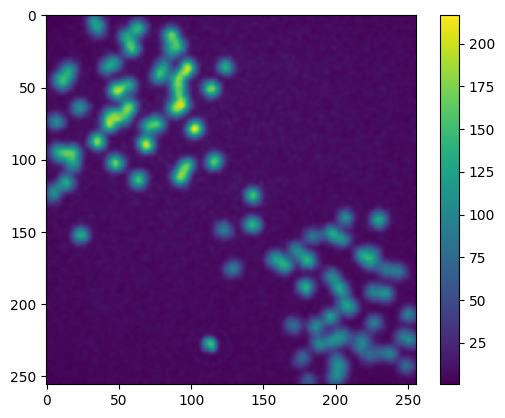

In [ ]:
plt.imshow(add_noise(images_distorted_wo_darkfield[nuc_channel_idx, 100]))
plt.colorbar()

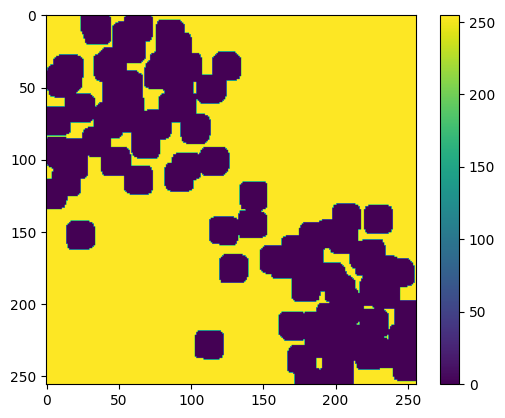

In [ ]:
plt.imshow(weights[nuc_channel_idx, 100])
plt.colorbar()